# Mục Đích
> Trong phần này chúng ta sẽ học chi tiết hơn về RNN (recurrent neural network) cho dữ liệu dạng sequences (words sau khi đã được tokenize). Và kiến trúc kinh điển của RNN là LSTM (long-short term memory).

In [ ]:
import tensorflow as tf
import tensorflow.keras as keras
import tensorflow.keras.preprocessing.text as text
import tensorflow.keras.preprocessing.sequence as sequence
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import numpy as np
import json

In [ ]:
tf.config.experimental.list_physical_devices('GPU')

[]

In [ ]:
!ls

00_Tokenization.ipynb	 02_RNN.ipynb  sarcasm_meta.tsv     vectors.tsv
01_Word_Embedding.ipynb  meta.tsv      sarcasm_vectors.tsv  word_projector.jpg


# Load Dữ liệu
> Chúng ta vẫn sẽ sử dụng dữ liệu Sarcasm cho vị dụ về RNN và LSTMs ở đây.

In [ ]:
file_name = '/home/ddpham/git/TFExam/data/Sarcasm_Headlines_Dataset.json'
sentences = []
labels = []
with open(file_name, 'r') as file:
    for line in file.readlines():
        data = json.loads(line)
        sentences.append(data['headline'])
        labels.append(data['is_sarcastic'])
file.close()

In [ ]:
len(sentences)

26709

# Tokenizer

In [ ]:
# Tokenize:
num_words = 1000
oov_tok = 'UNK'
train_size = 20000

tokenizer = text.Tokenizer(num_words=num_words, oov_token=oov_tok)
train_sentences = sentences[:train_size]
valid_sentences = sentences[train_size:]
train_labels = np.array(labels[:train_size])
valid_labels = np.array(labels[train_size:])

tokenizer.fit_on_texts(train_sentences)
word_index = tokenizer.word_index
train_sequences = tokenizer.texts_to_sequences(train_sentences)
valid_sequences = tokenizer.texts_to_sequences(valid_sentences)

# Pad:
max_len = 20
embed_dim = 16
pad_type = 'post'
trunc_type = 'post'

train_sequences = sequence.pad_sequences(train_sequences, maxlen=max_len, padding=pad_type, truncating=trunc_type)
valid_sequences = sequence.pad_sequences(valid_sequences, maxlen=max_len, padding=pad_type, truncating=trunc_type)
train_sequences.shape, valid_sequences.shape

((20000, 20), (6709, 20))

# Tạo model
> Chúng ta sẽ sử dụng model với LSTM bằng cách kết hợp giữa `Bidirectional` và `LSTM`. Lưu ý, Bidirectional chỉ là vỏ bọc của LSTM để hỗ trợ việc tạo ra sequence_processing, thỏa mãn các điều kiện về  sử dụng historical states của RNN hay LSTMs.

In [ ]:
model = keras.Sequential([
    keras.layers.Embedding(num_words, embed_dim, input_length=max_len)
    , keras.layers.Bidirectional(keras.layers.LSTM(max_len))
    , keras.layers.Dense(max_len, activation='relu')
    , keras.layers.Dense(1, activation='sigmoid')
])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics='accuracy')
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 20, 16)            16000     
_________________________________________________________________
bidirectional (Bidirectional (None, 40)                5920      
_________________________________________________________________
dense (Dense)                (None, 20)                820       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 21        
Total params: 22,761
Trainable params: 22,761
Non-trainable params: 0
_________________________________________________________________


In [ ]:
epochs=10
model.fit(train_sequences, train_labels, epochs=epochs, validation_data=(valid_sequences, valid_labels))

Epoch 1/10
625/625 [==============================] - 7s 8ms/step - loss: 0.5476 - accuracy: 0.7019 - val_loss: 0.4066 - val_accuracy: 0.8100
Epoch 2/10
625/625 [==============================] - 4s 7ms/step - loss: 0.3514 - accuracy: 0.8372 - val_loss: 0.3759 - val_accuracy: 0.8258
Epoch 3/10
625/625 [==============================] - 4s 6ms/step - loss: 0.3172 - accuracy: 0.8592 - val_loss: 0.3881 - val_accuracy: 0.8211
Epoch 4/10
625/625 [==============================] - 4s 6ms/step - loss: 0.3021 - accuracy: 0.8668 - val_loss: 0.3854 - val_accuracy: 0.8290
Epoch 5/10
625/625 [==============================] - 4s 6ms/step - loss: 0.2962 - accuracy: 0.8672 - val_loss: 0.3750 - val_accuracy: 0.8341
Epoch 6/10
625/625 [==============================] - 4s 6ms/step - loss: 0.2724 - accuracy: 0.8832 - val_loss: 0.3799 - val_accuracy: 0.8316
Epoch 7/10
625/625 [==============================] - 4s 7ms/step - loss: 0.2788 - accuracy: 0.8790 - val_loss: 0.3911 - val_accuracy: 0.8334
Epoch 

Chúng ta có thể thấy, chỉ với 2 epochs thôi mà kết quả đã tốt hơn so với kết quả trong phần trước (Word-Embedding).

Chúng ta cũng có thể tạo thêm 1 Bidirectial layers phía sau 1 Bidirectional được. Hãy thử với tình huống này:

In [ ]:
model = keras.Sequential([
    keras.layers.Embedding(num_words, embed_dim, input_length=20),
    # Để có thêm 1 layer nữa của Bidirectional, chúng ta phải thêm return_sequences=T trong LSTM:
    keras.layers.Bidirectional(keras.layers.LSTM(20, return_sequences=True)), 
    keras.layers.Bidirectional(keras.layers.LSTM(10)),
    keras.layers.Dense(10, activation='relu'),
    keras.layers.Dense(1, activation='sigmoid')
])
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 20, 16)            16000     
_________________________________________________________________
bidirectional_1 (Bidirection (None, 20, 40)            5920      
_________________________________________________________________
bidirectional_2 (Bidirection (None, 20)                4080      
_________________________________________________________________
dense_2 (Dense)              (None, 10)                210       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 11        
Total params: 26,221
Trainable params: 26,221
Non-trainable params: 0
_________________________________________________________________


In [ ]:
epochs = 10
model.fit(train_sequences, train_labels, epochs=epochs, validation_data=(valid_sequences, valid_labels))

Epoch 1/10
625/625 [==============================] - 89s 136ms/step - loss: 0.5358 - accuracy: 0.7094 - val_loss: 0.3967 - val_accuracy: 0.8174
Epoch 2/10
625/625 [==============================] - 83s 133ms/step - loss: 0.3714 - accuracy: 0.8317 - val_loss: 0.3880 - val_accuracy: 0.8235
Epoch 3/10
625/625 [==============================] - 81s 129ms/step - loss: 0.3572 - accuracy: 0.8376 - val_loss: 0.3862 - val_accuracy: 0.8272
Epoch 4/10
625/625 [==============================] - 82s 131ms/step - loss: 0.3456 - accuracy: 0.8424 - val_loss: 0.3795 - val_accuracy: 0.8274
Epoch 5/10
625/625 [==============================] - 82s 131ms/step - loss: 0.3376 - accuracy: 0.8468 - val_loss: 0.3946 - val_accuracy: 0.8155
Epoch 6/10
625/625 [==============================] - 66s 105ms/step - loss: 0.3271 - accuracy: 0.8524 - val_loss: 0.3784 - val_accuracy: 0.8295
Epoch 7/10
625/625 [==============================] - 58s 92ms/step - loss: 0.3207 - accuracy: 0.8567 - val_loss: 0.3718 - val_acc

Với kết quả ở trên, chúng ta có thể thấy khoảng cách giữa accuracy của tập train và valid được thu hẹp lại đáng kể, cho thấy mức độ overfit của model được giảm đi.

# Subword Tokenizer
> Trong bài trước chúng ta cũng có đề cập về subword tokenizer, tuy nhiên chưa thực hiện. Ở đây chúng ta sẽ bàn về subword tokenizer nhiều hơn. Subword tokenizer được áp dụng cho phương pháp BERT.

Để sử dụng được subwork tokenizer, chúng ta cần cài đặt tensorflow-text.

In [ ]:
# !pip install tensorflow-text

  Using cached tensorflow_text-2.4.3-cp38-cp38-manylinux1_x86_64.whl (3.4 MB)
  Using cached tensorflow_hub-0.12.0-py2.py3-none-any.whl (108 kB)
  Using cached opt_einsum-3.3.0-py3-none-any.whl (65 kB)
  Using cached flatbuffers-1.12-py2.py3-none-any.whl (15 kB)
  Using cached grpcio-1.32.0-cp38-cp38-manylinux2014_x86_64.whl (3.8 MB)
  Attempting uninstall: grpcio
    Found existing installation: grpcio 1.36.1
    Uninstalling grpcio-1.36.1:
      Successfully uninstalled grpcio-1.36.1
  Attempting uninstall: opt-einsum
    Found existing installation: opt-einsum 3.1.0
    Uninstalling opt-einsum-3.1.0:
      Successfully uninstalled opt-einsum-3.1.0
  Attempting uninstall: flatbuffers
    Found existing installation: flatbuffers 20210226132247
    Uninstalling flatbuffers-20210226132247:
      Successfully uninstalled flatbuffers-20210226132247


In [ ]:
import tensorflow_text as tftext

NotFoundError: /home/ddpham/anaconda3/envs/tf/lib/python3.8/site-packages/tensorflow_text/python/metrics/_text_similarity_metric_ops.so: undefined symbol: _ZNK10tensorflow8OpKernel11TraceStringERKNS_15OpKernelContextEb

Hiện tại mình đang bị lỗi này với WSL của Windows mà chưa thể sửa được khi sử dụng cả tensorflow-gpu và tensorflow-text. Nếu mình chỉ cài tensorflow thì sẽ không thể dùng được gpu, nhưng lại dùng được tensorflow_text. Còn nếu cài tensorflow-gpu thì sẽ dùng được GPU, nhưng ko sài được tensorflow_text. Đây là vấn đề với WSL ở thời điểm hiện tại mà chưa thể xử lý được.

Chúng ta sẽ dùng tool khác để sử lý bài toán về subword-tokenizer này. Hoặc thay vì tự làm, chúng ta có thể sử dụng luôn dữ liệu đã có sẵn rồi.

## Sử dụng dữ liệu imdb_subword
> Dữ liệu review phim đã được tokenizer dưới dạng subword. 

In [ ]:
# sử dụng review 8k:
dataset, info = tfds.load('imdb_reviews/subwords8k', with_info=True, as_supervised=True)

In [ ]:
train_ds, valid_ds = dataset['train'], dataset['test']

In [ ]:
tokenizer = info.features['text'].encoder

In [ ]:
dir(tokenizer)

['__abstractmethods__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_abc_impl',
 '_build_from_token_counts',
 '_byte_encode',
 '_cache_size',
 '_filename',
 '_id_to_subword',
 '_init_from_list',
 '_max_subword_len',
 '_read_lines_from_file',
 '_subword_to_id',
 '_subwords',
 '_token_to_ids',
 '_token_to_ids_cache',
 '_token_to_subwords',
 '_tokenizer',
 '_write_lines_to_file',
 'build_from_corpus',
 'decode',
 'encode',
 'load_from_file',
 'save_to_file',
 'subwords',
 'vocab_size']

In [ ]:
tokenizer.subwords

['the_',
 ', ',
 '. ',
 'a_',
 'and_',
 'of_',
 'to_',
 's_',
 'is_',
 'br',
 'in_',
 'I_',
 'that_',
 'this_',
 'it_',
 ' /><',
 ' />',
 'was_',
 'The_',
 'as_',
 't_',
 'with_',
 'for_',
 '.<',
 'on_',
 'but_',
 'movie_',
 ' (',
 'are_',
 'his_',
 'have_',
 'film_',
 'not_',
 'ing_',
 'be_',
 'ed_',
 'you_',
 ' "',
 'it',
 'd_',
 'an_',
 'he_',
 'by_',
 'at_',
 'one_',
 'who_',
 'y_',
 'from_',
 'e_',
 'or_',
 'all_',
 'like_',
 'they_',
 '" ',
 'so_',
 'just_',
 'has_',
 ') ',
 'her_',
 'about_',
 'out_',
 'This_',
 'some_',
 'ly_',
 'movie',
 'film',
 'very_',
 'more_',
 'It_',
 'would_',
 'what_',
 'when_',
 'which_',
 'good_',
 'if_',
 'up_',
 'only_',
 'even_',
 'their_',
 'had_',
 'really_',
 'my_',
 'can_',
 'no_',
 'were_',
 'see_',
 'she_',
 '? ',
 'than_',
 '! ',
 'there_',
 'get_',
 'been_',
 'into_',
 ' - ',
 'will_',
 'much_',
 'story_',
 'because_',
 'ing',
 'time_',
 'n_',
 'we_',
 'ed',
 'me_',
 ': ',
 'most_',
 'other_',
 'don',
 'do_',
 'm_',
 'es_',
 'how_',
 'also

In [ ]:
BUFFER_SIZE = 10000
BATCH_SIZE = 64

train_ds = train_ds.shuffle(BUFFER_SIZE)
train_ds = train_ds.padded_batch(BATCH_SIZE, tf.compat.v1.data.get_output_shapes(train_ds))
valid_ds = valid_ds.padded_batch(BATCH_SIZE, tf.compat.v1.data.get_output_shapes(valid_ds))

In [ ]:
model = keras.Sequential([
    keras.layers.Embedding(tokenizer.vocab_size, 64),
    keras.layers.Bidirectional(keras.layers.LSTM(64, return_sequences=True)),
    keras.layers.Bidirectional(keras.layers.LSTM(32)),
    keras.layers.Dense(20, activation='relu'),
    keras.layers.Dense(1, activation='sigmoid')
])
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 64)          523840    
_________________________________________________________________
bidirectional_1 (Bidirection (None, None, 128)         66048     
_________________________________________________________________
bidirectional_2 (Bidirection (None, 64)                41216     
_________________________________________________________________
dense_2 (Dense)              (None, 20)                1300      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 21        
Total params: 632,425
Trainable params: 632,425
Non-trainable params: 0
_________________________________________________________________


In [ ]:
epochs=5
model.fit(train_ds, epochs=epochs, validation_data=valid_ds)

Epoch 1/5
391/391 [==============================] - 1275s 3s/step - loss: 0.5905 - accuracy: 0.6699 - val_loss: 0.4172 - val_accuracy: 0.8294
Epoch 2/5
391/391 [==============================] - 1192s 3s/step - loss: 0.3539 - accuracy: 0.8581 - val_loss: 0.4044 - val_accuracy: 0.8287
Epoch 3/5
391/391 [==============================] - 1054s 3s/step - loss: 0.3232 - accuracy: 0.8658 - val_loss: 0.4362 - val_accuracy: 0.8110
Epoch 4/5
391/391 [==============================] - 1047s 3s/step - loss: 0.3131 - accuracy: 0.8748 - val_loss: 0.3944 - val_accuracy: 0.8305
Epoch 5/5
391/391 [==============================] - 1033s 3s/step - loss: 0.3310 - accuracy: 0.8634 - val_loss: 0.3961 - val_accuracy: 0.8316


In [ ]:
def plot_history(history):
    item_dict = {'Loss': ['loss', 'val_loss'], 'Accuracy': ['accuracy', 'val_accuracy']}
    plot_list = ['Loss', 'Accuracy']
    plt.figure(figsize=(8, 4))
    for i in range(len(plot_list)):
        plt.subplot(1, 2, i+1)
        item = plot_list[i]
        for items in item_dict[item]:
            plt.plot(history.history[items])
        plt.legend(item_dict[item])
    plt.tight_layout()

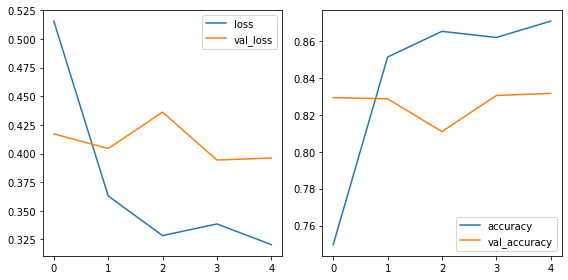

In [ ]:
plot_history(model.history)